In [21]:
# Add print statements for debugging

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import glob

Downsampling Function

In [23]:
# Downsampling using average pooling
"""
Downsample the input array to 35 elements using interpolation.
"""

def downsample_to_35(input_array):
    input_tensor = torch.tensor(input_array, dtype=torch.float32)
    
    # Reshape the input to be 1D (if it's not already)
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, original_length)
    elif input_tensor.dim() == 2:
        input_tensor = input_tensor.unsqueeze(0)  # Shape (1, original_channels, original_length)
    
    # Perform interpolation to downsample to 35 elements
    downsampled_tensor = F.interpolate(input_tensor, size=35, mode='linear', align_corners=True)
    
    # Remove the unnecessary dimensions to return a 1D tensor
    downsampled_array = downsampled_tensor.squeeze().numpy()
    
    return downsampled_array

Data Collection

In [24]:
# Read airfoil coordinates from the text file
# file path
file_path = './airfoil_training_data/'


# Initialize arrays to store elements from each column

x_i = []
y_i = []

for coordinate_file in glob.glob(file_path+'*_coordinates.txt'):
    # print(coordinate_file)
    x = []
    y = []
    with open(coordinate_file, 'r') as file:
        for line in file:
            # Split the line into two parts based on whitespace
            elements = line.split()
            # Append the elements to the respective arrays
            x.append(float(elements[0]))
            y.append(float(elements[1]))
    
    x = np.array(x)
    y = np.array(y)
    
    x_i.append(x)
    y_i.append(y)

print(len(x_i))


12


In [42]:
# Read the polar file and add alpha, M, Cl and Cd to an array

alphas = []
Cls = []
Cds = []

for polar_file in glob.glob(file_path+'xf-*'):
    # print(polar_file)
    polars = pd.read_csv(polar_file, skiprows=10)
    polars = polars[(polars['Alpha'] >= -3) & (polars['Alpha'] <= 10)]
    alpha = polars['Alpha'].values
    Cl = polars['Cl'].values
    Cd = polars['Cd'].values
    alphas.append(alpha)
    for num_val in range(len(Cl)):
        # alphas.append(alpha[num_val])
        Cls.append(Cl[num_val])
        Cds.append(Cd[num_val])

print(polars)

Cls_train = np.array(Cls, dtype=float) 

# print(type(Cls_train))
print(Cls_train.shape)
# print(len(alphas))

    Alpha      Cl       Cd      Cdp      Cm  Top_Xtr  Bot_Xtr
0   -2.00  0.0265  0.00774  0.00206 -0.0513   0.6493   0.3379
1   -1.75  0.0537  0.00769  0.00202 -0.0511   0.6366   0.3544
2   -1.50  0.0807  0.00765  0.00199 -0.0509   0.6235   0.3729
3   -1.25  0.1081  0.00759  0.00196 -0.0507   0.6111   0.3934
4   -1.00  0.1348  0.00754  0.00195 -0.0504   0.5982   0.4177
5   -0.75  0.1614  0.00751  0.00194 -0.0500   0.5841   0.4428
6   -0.50  0.1885  0.00747  0.00194 -0.0498   0.5708   0.4685
7   -0.25  0.2149  0.00742  0.00195 -0.0494   0.5580   0.5006
8    0.00  0.2416  0.00739  0.00198 -0.0491   0.5464   0.5317
9    0.25  0.2689  0.00736  0.00200 -0.0489   0.5368   0.5565
10   0.50  0.2961  0.00737  0.00203 -0.0487   0.5271   0.5786
11   0.75  0.3235  0.00736  0.00207 -0.0485   0.5190   0.6000
12   1.00  0.3511  0.00736  0.00210 -0.0483   0.5106   0.6203
13   1.25  0.3781  0.00740  0.00215 -0.0481   0.5017   0.6404
14   1.50  0.4059  0.00738  0.00220 -0.0479   0.4938   0.6616
15   1.7

In [26]:
# Downsample to 35 elements
ds_x_i = []
ds_y_i = []
for num_airfoil in range(0, len(x_i)):
    downsampled_x = downsample_to_35(x_i[num_airfoil])
    downsampled_y = downsample_to_35(y_i[num_airfoil])

    ds_x_i.append(downsampled_x)
    ds_y_i.append(downsampled_y)
    # print(f"Original x array length: {x_i[num_airfoil].shape[-1]}")
    # print(f"Downsampled x array length: {downsampled_x.shape[-1]}")

    # print(f"Original y array length: {y_i[num_airfoil].shape[-1]}")
    # print(f"Downsampled y array length: {downsampled_y.shape[-1]}")
print(len(ds_x_i))

12


## Arrange the data in the form of elements
* $E = [E_1, E_2, ....., E_n]$ 
* $E_1 = [x_1, y_1, x_2, y_2, \alpha]$

In [27]:
# Arange the input data in columns [x, y, alpha, Re, M]

Elements = []

# Loop through the polars
for num_file in range(len(ds_x_i)):
    x_temp = ds_x_i[num_file]
    y_temp = ds_y_i[num_file]
    alpha_temp = alphas[num_file]
    for j in range(len(alpha_temp)):
        batch = []
        
        # Loop through the coodrinates
        for i in range(len(x_temp)-1):
            element = np.array([x_temp[i], y_temp[i], x_temp[i+1], y_temp[i+1], alpha_temp[j]])
            # Elements.append(element)
            batch.append(element)
        batch = np.array(batch)
        batch = batch.flatten()
        Elements.append(batch)

Elements_train = np.array(Elements)

# print(Elements.shape)
# print(len(alphas))

In [28]:
print(Elements_train.shape)
print(Cls_train.shape)

(661, 170)
(661,)


## Neural Network Model

In [29]:
# Element Spatial Convolutional Neural Network model

class ESCNN(nn.Module):
    def __init__(self):
        super(ESCNN, self).__init__()
        
        # Conv1: Assume 1D Convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5, stride=5)
        self.relu1 = nn.ReLU()
        
        # Conv2
        self.conv2 = nn.Conv1d(in_channels=200, out_channels=1, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        
        # Final fully connected layer to output scalar
        self.fc = nn.Linear(in_features=34, out_features=1)
    
    def forward(self, x):
        # Reshape input if necessary, ensure it's in the shape (batch_size, channels, elements)
        x = x.view(-1, 1, 170)  # Reshape to (batch_size, channel=1, elements=170)
        
        x = self.conv1(x)  # (batch_size, 200, 34)
        x = self.relu1(x)
        
        x = self.conv2(x)  # (batch_size, 1, 34)
        x = self.relu2(x)
        
        # x = x.view(x.size(0), -1)  # Flatten (batch_size, 31)
        x = torch.flatten(x, 1)
        
        x = self.fc(x)  # (batch_size, 1)
        
        return x

model = ESCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ESCNN(
  (conv1): Conv1d(1, 200, kernel_size=(5,), stride=(5,))
  (relu1): ReLU()
  (conv2): Conv1d(200, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (fc): Linear(in_features=34, out_features=1, bias=True)
)

Split the data

In [30]:
# from sklearn.model_selection import train_test_split

# Elements_train, Elements_test, Cls_train, Cls_test = train_test_split(Elements, Cls, test_size=0.2, random_state=28)

Arrange the Data

In [31]:
# Prepare the data for the model

input_data = Elements_train
output_data = Cls_train

# Convert to PyTorch tensors
input_data = torch.tensor(input_data, dtype=torch.float32)
# input_data = input_data.unsqueeze(1)
output_data = torch.tensor(output_data, dtype=torch.float32)

# Move data to GPU if available
input_data = input_data.to(device)

output_data = output_data.to(device)

# DataLoader
from torch.utils.data import TensorDataset, DataLoader

# Create dataset and dataloader
dataset = TensorDataset(input_data, output_data)
dataloader = DataLoader(dataset, batch_size=128)

## Train the Model

In [32]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.000001)

# Training loop
num_epochs = 500
L = {"train_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    
    for inputs, targets in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss
        avgRunning_loss = running_loss/len(dataloader.dataset)
        
        # Keep track of the losses
        L["train_loss"].append(avgRunning_loss.detach().cpu().numpy())
    
    # Print loss per epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader.dataset)}")

print("Finished Training")

Epoch 1/500, Loss: 0.004934388678520918


c:\Users\hegde\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\hegde\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/500, Loss: 0.004913831129670143
Epoch 3/500, Loss: 0.004894408397376537
Epoch 4/500, Loss: 0.004872372839599848
Epoch 5/500, Loss: 0.00485265115275979
Epoch 6/500, Loss: 0.004835098050534725
Epoch 7/500, Loss: 0.004814943298697472
Epoch 8/500, Loss: 0.0047950539737939835
Epoch 9/500, Loss: 0.0047774845734238625
Epoch 10/500, Loss: 0.004758642055094242
Epoch 11/500, Loss: 0.00473911315202713
Epoch 12/500, Loss: 0.004719116725027561
Epoch 13/500, Loss: 0.004702768288552761
Epoch 14/500, Loss: 0.004683910869061947
Epoch 15/500, Loss: 0.004664471838623285
Epoch 16/500, Loss: 0.004646829329431057
Epoch 17/500, Loss: 0.004630109295248985
Epoch 18/500, Loss: 0.004611349664628506
Epoch 19/500, Loss: 0.004592445213347673
Epoch 20/500, Loss: 0.0045759789645671844
Epoch 21/500, Loss: 0.004558633081614971
Epoch 22/500, Loss: 0.004541109316051006
Epoch 23/500, Loss: 0.00452354596927762
Epoch 24/500, Loss: 0.004508132580667734
Epoch 25/500, Loss: 0.0044902474619448185
Epoch 26/500, Loss: 0.0

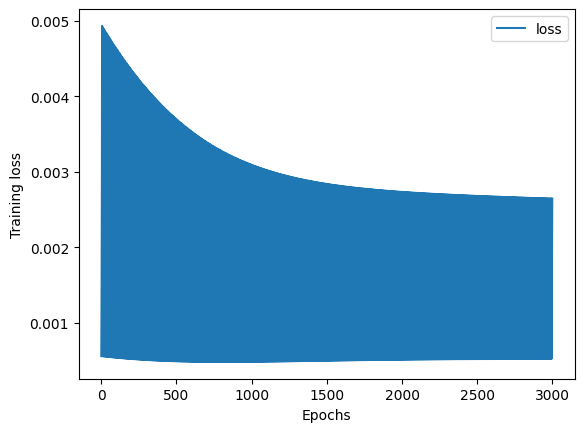

In [33]:
# Plot the loss

# plt.plot(range(num_epochs), losses)
plt.plot(L["train_loss"], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

## Evaluate the model

In [34]:
# Read airfoil coordinates from the text file
# file path
file_path = './airfoil_test_data/'


# Initialize arrays to store elements from each column

x_t = []
y_t = []

for coordinate_file in glob.glob(file_path+'*_coordinates.txt'):
    # print(coordinate_file)
    x = []
    y = []
    with open(coordinate_file, 'r') as file:
        for line in file:
            # Split the line into two parts based on whitespace
            elements = line.split()
            # Append the elements to the respective arrays
            x.append(float(elements[0]))
            y.append(float(elements[1]))
    
    x = np.array(x)
    y = np.array(y)
    
    x_t.append(x)
    y_t.append(y)


In [35]:
# Read the polar file and add alpha, M, Cl and Cd to an array

alphas_t = []
Cls_t = []
Cds_t = []

for polar_file in glob.glob(file_path+'xf-*'):
    # print(polar_file)
    polars_t = pd.read_csv(polar_file, skiprows=10)
    alpha_t = polars_t['Alpha'].values
    Cl_t = polars_t['Cl'].values
    Cd_t = polars_t['Cd'].values
    alphas_t.append(alpha_t)
    for num_val in range(len(Cl_t)):
        # alphas.append(alpha[num_val])
        Cls_t.append(Cl_t[num_val])
        Cds_t.append(Cd_t[num_val])


Cls_test = np.array(Cls_t, dtype=float)

# print(len(alpha_t))

In [36]:
# Downsample to 35 elements
ds_x_t = []
ds_y_t = []
for num_airfoil in range(0, len(x_t)):
    downsampled_x = downsample_to_35(x_t[num_airfoil])
    downsampled_y = downsample_to_35(y_t[num_airfoil])

    ds_x_t.append(downsampled_x)
    ds_y_t.append(downsampled_y)


In [37]:
# Arange the input data in columns [x, y, alpha, Re, M]

Elements_t = []

# Loop through the polars
for num_file in range(len(ds_x_t)):
    x_temp = ds_x_t[num_file]
    y_temp = ds_y_t[num_file]
    alpha_temp = alphas_t[num_file]
    for j in range(len(alpha_temp)):
        batch = []
        
        # Loop through the coodrinates
        for i in range(len(x_temp)-1):
            element = np.array([x_temp[i], y_temp[i], x_temp[i+1], y_temp[i+1], alpha_temp[j]])
            # Elements.append(element)
            batch.append(element)
        batch = np.array(batch)
        batch = batch.flatten()
        Elements_t.append(batch)

Elements_test = np.array(Elements_t)

In [38]:
print(Elements_test.shape)
print(Cls_test.shape)

(67, 170)
(67,)


In [39]:
input_data_test = Elements_test

# Convert to PyTorch tensors
input_data_test = torch.tensor(input_data_test, dtype=torch.float32)

# Move data to GPU
input_data_test = input_data_test.to(device)

# Evaluate the model on test dataset
with torch.no_grad():
    Cl_eval = model.forward(input_data_test)
    # loss = criterion(Cl_eval, Cls_test[0])

Text(0, 0.5, '$C_l$')

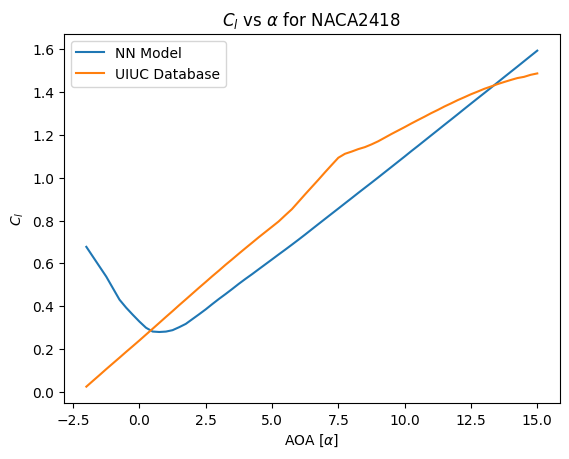

In [40]:
plt.plot(alpha_t, Cl_eval.cpu().numpy())
plt.plot(alpha_t,Cls_t)

plt.legend(['NN Model', 'UIUC Database'])
plt.title(r'$C_l$ vs $\alpha$ for NACA2418')
plt.xlabel(r'AOA [$\alpha$]')
plt.ylabel(r'$C_l$')